O objetivo desse notebook é treinar uma modelo que generalize a limpeza de imagens com caracters apartir de imagens sintéticas criadas a partir do wikipedia com auxilio do modulo trdg.

A função background_image image abaixo é responsavel por criar os backgrounds que serão utilizados nas imagens de texto sintetizadas.

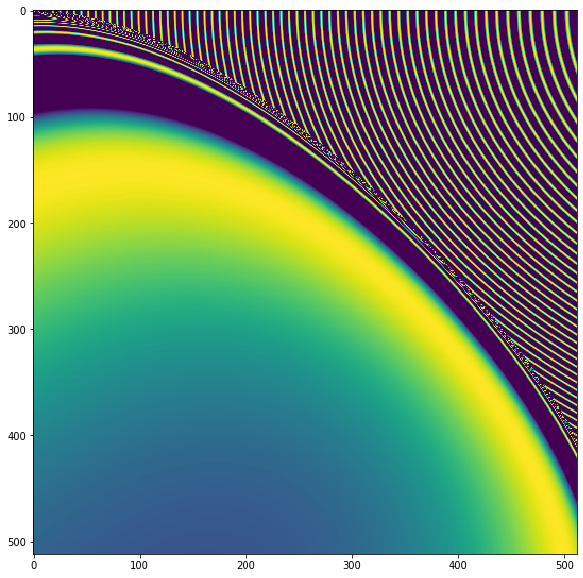

In [7]:
import numpy as np, random
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from scipy.spatial import ConvexHull
plt.rcParams['figure.figsize'] = [10, 10]


def background_image(shape, mini):
    dX, dY = shape[::-1]
    xArray = np.linspace(0.0, 1.0, dX).reshape((1, dX, 1))
    yArray = np.linspace(0.0, 1.0, dY).reshape((dY, 1, 1))

    def randColor():
        return np.array([random.random(), random.random(), random.random()]).reshape((1, 1, 3))
    def getX(): return xArray
    def getY(): return yArray
    def safeDivide(a, b):
        return np.divide(a, np.maximum(b, 0.001))

    functions = [(0, randColor),
                 (0, getX),
                 (0, getY),
                 (1, np.sin),
                 (1, np.cos),
                 (2, np.add),
                 (2, np.subtract),
                 (2, np.multiply),
                 (2, safeDivide)]
    depthMin = 2
    depthMax = 10

    def buildImg(depth = 0):
        funcs = [f for f in functions if
                    (f[0] > 0 and depth < depthMax) or
                    (f[0] == 0 and depth >= depthMin)]
        nArgs, func = random.choice(funcs)
        args = [buildImg(depth + 1) for n in range(nArgs)]
        return func(*args)

    img = buildImg()

    # Ensure it has the right dimensions, dX by dY by 3
    img = np.tile(img, (dX // img.shape[0], dY // img.shape[1], 3 // img.shape[2]))

    # Convert to 8-bit, send to PIL and save
    img8Bit = np.uint8(np.rint(img.clip((mini + random.choice(list(range(40,100))))/255, 1.0) * 255.0))
    return img8Bit[..., random.choice(list(range(img8Bit.shape[-1])))]

plt.imshow(background_image([512,512], 20))

Abaixo temos a definição da Unet modificada para também retornar um feature map intermediário que é utilizado como entrada pelo modelo de segmentação de texto. Eu escolhi essa modificação por que no momento que eu optei por criar também a segmentação de texto eu ja tinha os pesos para a Unet original bem treinados ,assim sendo eu não queria começar todo o treinamento do Zero.


Também é criado a classe InfinityWordDataset onde são produzidas as infinitas imagens utilizadas no treinamento do modelo.

In [8]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import random
import torchvision


class UNetVgg(torch.nn.Module):
    def __init__(self, nClasses):
        super(UNetVgg, self).__init__()

        vgg16pre = torchvision.models.vgg16(pretrained=True)
        self.vgg0 = torch.nn.Sequential(*list(vgg16pre.features.children())[:4])
        self.vgg1 = torch.nn.Sequential(*list(vgg16pre.features.children())[4:9])
        self.vgg2 = torch.nn.Sequential(*list(vgg16pre.features.children())[9:16])
        self.vgg3 = torch.nn.Sequential(*list(vgg16pre.features.children())[16:23])
        self.vgg4 = torch.nn.Sequential(*list(vgg16pre.features.children())[23:30])



        self.smooth0 = torch.nn.Sequential(
                torch.nn.Conv2d(128, 64, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True)
                )
        self.smooth1 = torch.nn.Sequential(
                torch.nn.Conv2d(256, 64, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True)
                )
        self.smooth2 = torch.nn.Sequential(
                torch.nn.Conv2d(512, 128, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True)
                )
        self.smooth3 = torch.nn.Sequential(
                torch.nn.Conv2d(1024, 256, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True)
                )

        self.final = torch.nn.Conv2d(64, nClasses, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        Args:
            x (torch.tensor): A tensor of size (batch, 3, H, W)
        Returns:
            reg_out (torch.tensor): A tensor with results of the regression (batch, 4).
            cls_out (torch.tensor): A tensor with results of the classification (batch, 2).
        """

        feat0 = self.vgg0(x)
        feat1 = self.vgg1(feat0)
        feat2 = self.vgg2(feat1)
        feat3 = self.vgg3(feat2)
        feat4 = self.vgg4(feat3)

        _,_,H,W = feat3.size()
        up3 = torch.nn.functional.interpolate(feat4, size=(H,W), mode='bilinear', align_corners=False)
        concat3 = torch.cat([feat3, up3], 1)
        end3 = self.smooth3(concat3)

        _,_,H,W = feat2.size()
        up2 = torch.nn.functional.interpolate(end3, size=(H,W), mode='bilinear', align_corners=False)
        concat2 = torch.cat([feat2, up2], 1)
        end2 = self.smooth2(concat2)

        _,_,H,W = feat1.size()
        up1 = torch.nn.functional.interpolate(end2, size=(H,W), mode='bilinear', align_corners=False)
        concat1 = torch.cat([feat1, up1], 1)
        end1 = self.smooth1(concat1)

        _,_,H,W = feat0.size()
        up0 = torch.nn.functional.interpolate(end1, size=(H,W), mode='bilinear', align_corners=False)
        concat0 = torch.cat([feat0, up0], 1)
        end0 = self.smooth0(concat0)

        return self.final(end0), end2


    @staticmethod
    def get_params_by_kind(model, n_base = 7):

        base_vgg_bias = []
        base_vgg_weight = []
        core_weight = []
        core_bias = []

        for name, param in model.named_parameters():
            if 'vgg' in name and ('weight' in name or 'bias' in name):
                vgglayer = int(name.split('.')[-2])

                if vgglayer <= n_base:
                    if 'bias' in name:
                        print('Adding %s to base vgg bias.' % (name))
                        base_vgg_bias.append(param)
                    else:
                        base_vgg_weight.append(param)
                        print('Adding %s to base vgg weight.' % (name))
                else:
                    if 'bias' in name:
                        print('Adding %s to core bias.' % (name))
                        core_bias.append(param)
                    else:
                        print('Adding %s to core weight.' % (name))
                        core_weight.append(param)

            elif ('weight' in name or 'bias' in name):
                if 'bias' in name:
                    print('Adding %s to core bias.' % (name))
                    core_bias.append(param)
                else:
                    print('Adding %s to core weight.' % (name))
                    core_weight.append(param)

        return (base_vgg_weight, base_vgg_bias, core_weight, core_bias)

    
# End class




import numpy as np
from torch.utils.data import Dataset
import json
import cv2
import torch
import os.path as osp
import glob
from trdg.generators import GeneratorFromWikipedia

class InfinityWordDataset(Dataset):
    """Segmentation dataset loader."""

    def __init__(self, is_train, total_samples = 100, resolution=None, augmentation=False, transform=None):


        self.total_samples = total_samples
        self.is_train = is_train
        self.transform = transform
        self.augmentation = augmentation
        self.resolution = resolution
        self.fake_data = []
        self.class_to_id = {'char':1, 'Background':0}
        self.image_generator = GeneratorFromWikipedia(random_skew=True,background_type=1)
        self.regenerate()
        
    def __len__(self):
        return self.total_samples
    def regenerate(self):
        
        self.fake_data = []
        for i,(img, lbl) in enumerate(self.image_generator):
            if i > self.total_samples:
                break
            self.fake_data.append(img)

    def __getitem__(self, idx):

                
        text_image = cv2.cvtColor(np.array(self.fake_data[idx]), cv2.COLOR_BGR2GRAY)
        if text_image.shape[1] > 512:
            text_image = text_image[:,:512]
            
        th3 = cv2.adaptiveThreshold(text_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,155,15)

        repeat = random.randint(3,10)
        text_image = np.vstack(tuple([text_image if i % 2 ==0 else np.fliplr(text_image) for i in range(repeat)]))
        th3 = np.vstack(tuple([th3 if i % 2 ==0 else np.fliplr(th3) for i in range(repeat)]))
        
        back_image = background_image([512,512], text_image.min())
        
        v_border = random.randint(15, int(0.8 * text_image.shape[0]))
        h_border = random.randint(15, int(0.8 * text_image.shape[1]))
        back_image = cv2.resize(back_image,(int(text_image.shape[1] + 2*h_border),int(text_image.shape[0]+ 2*v_border)))
        
        border_th =  np.ones_like(back_image) *255
        border_th[v_border:-v_border,h_border:-h_border] = th3
        th3 = border_th
        
        if random.random()> 0.8:
            img_np = np.min(np.array([back_image]), axis=0)
            th3 = np.ones_like(th3) *255
        else:
            back_image[v_border:-v_border,h_border:-h_border] = np.min(np.array([text_image, back_image[v_border:-v_border,h_border:-h_border]]), axis=0)
            img_np =    back_image 
        original_shape = img_np.shape
        if self.resolution is not None:
            img_np = cv2.resize(
                img_np, (self.resolution[1], self.resolution[0]), interpolation=cv2.INTER_CUBIC)[..., ::-1]
        img_np = np.ascontiguousarray(img_np)
        img_np = cv2.normalize(img_np,  None, 0, 255, cv2.NORM_MINMAX)
        img_np = 255 - img_np
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
        # Cria imagem zerada
        # Transforma o GT em inteiro
        label_np = (th3 == 0).astype(np.int32)
        


        if self.is_train and self.augmentation:
            if np.random.rand() > 0.5:
                img_np = np.fliplr(img_np)
                label_np = np.fliplr(label_np)
                img_np = np.ascontiguousarray(img_np)
                label_np = np.ascontiguousarray(label_np)
            # if np.random.rand() > 0.2:
            #     img_np = np.roll(img_np, np.random.randint(
            #         0, 3, size=1)[0], axis=2)
            #     img_np = np.ascontiguousarray(img_np)
            # elif np.random.rand() > 0.2:
            #     gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            #     img_np[..., 0] = gray
            #     img_np[..., 1] = gray
            #     img_np[..., 2] = gray

            # if np.random.rand() < 1:
            #     img_np, label_np = self.distort_transform(
            #         img_np, label_np)

#             if np.random.rand() < 0.5:
#                 img_np = 255 - img_np
            
            if np.random.rand() < 0.9:
                aug_img_np, label_np = self.perspective_transforme(
                    img_np, label_np)
                img_np = (img_np*0.1 + aug_img_np*0.9).astype('u1')
            
            if np.random.rand() < 0.5:
                img_np, label_np = self.blur_transform(
                    img_np, label_np)

            if np.random.rand() < 0.5:
                img_np, label_np = self.noise_transform(
                    img_np, label_np)

        img_np = np.ascontiguousarray(img_np, dtype=np.float32)
        label_np = np.ascontiguousarray(label_np, dtype=np.float32)
        
        points = np.argwhere(label_np == 1)
        
        seg_gt = np.zeros_like(label_np)
        
        try:
            hull = ConvexHull(points)
            cnt = points[hull.vertices]
            cnt = cnt[...,::-1]



            cv2.fillPoly(seg_gt, pts =[cnt], color=(1,))
        except:
            pass
        img_pt = img_np.transpose(2, 0, 1)

        img_pt = torch.from_numpy(img_pt).float()
        label_pt = torch.from_numpy(label_np).long()
        seg_pt = torch.from_numpy(seg_gt).long()

        sample = {'image': img_pt, 'gt': label_pt,'seg_gt': seg_pt,'image_original': img_np}


        return sample
    def distort_transform(self, img, gt):
        h, w = img.shape[:2]

        # copy parameters to arrays
        K = np.array([[w, 0., w/2],
                    [0, h, h/2],
                    [0, 0, 1]]) 
    
        d = np.array([np.random.random_sample((1,))*0.15
                    , np.random.random_sample((1,))*0.15
                    , (np.random.random_sample((1,))-.5 )*0.005
                    , (np.random.random_sample((1,))-.5 )*0.005,
                    (np.random.random_sample((1,))-.5 )*0.001]) # just use first two terms 
        d = d.reshape(5)

        # undistort
        newcamera, roi = cv2.getOptimalNewCameraMatrix(K, d, (w,h), 0)
        newimg = cv2.undistort(img.astype(np.float32), K, d, None, newcamera)
        newgt = cv2.undistort(gt.astype(np.uint8), K, d, None, newcamera)
        return newimg.astype(np.float32), newgt.astype(np.int32)
    
    
    def perspective_transforme(self, img, gt):
        sz = img.shape[:2][::-1]
        src = np.array([
            [0, 0],
            [sz[0]-1, 0],
            [sz[0]-1, sz[1]-1],
            [0, sz[1]-1]], dtype="float32")
        warp_force = 0.2
        #src += np.array([sz[0]/2,sz[1]/2 ], dtype = "float32")
        rd = (np.random.random_sample(src.shape).astype(np.float32)*2 - 1) * \
            np.array([sz[0]*warp_force, sz[1]*warp_force], dtype="float32")
        dst = src + rd
        # calculate the perspective transform matrix and warp
        # the perspective to grab the screen
        M = cv2.getPerspectiveTransform(src, dst)
        return (cv2.warpPerspective(img.astype(np.float32), M, sz, borderMode=cv2.BORDER_REPLICATE)), cv2.warpPerspective(gt.astype(np.uint8), M, sz, borderMode=cv2.BORDER_CONSTANT,flags= cv2.INTER_NEAREST, borderValue=self.class_to_id['Background']).astype(np.int32)
    def blur_transform(self, img, gt):
        k = np.random.randint(3, 5)
        img = cv2.blur(img, (k, k))
        return img, gt

    def noise_transform(self, img, gt):
        prob = np.random.random_sample(img.shape)
        prob[prob >= 0.5] = (np.random.random_sample((1,))[0]*2-1)*50
        prob[prob < 0.5] = 0
        data32 = img + prob
        np.clip(data32, 0, 255, out=data32)
        img = data32.astype(np.float32)
        return img, gt

Missing modules for handwritten text generation.


Instanciando o InfinityWordDataset e criando um unico dataloader que sera utilizado tanto para o treinamento como para validação, na verdade o conceito de dataset de treinamento e validação ele se perde um pouco aqui ja que as imagens nunca se repetem sempre são geradas imagens novas.  
Nessa celula podemos ver exemplos sintetizados.

(1, 168, 1108) (1, 168, 1108)
(168, 1108, 3)


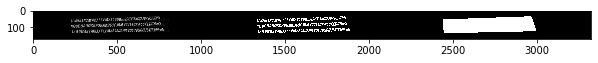

(1, 212, 216) (1, 212, 216)
(212, 216, 3)


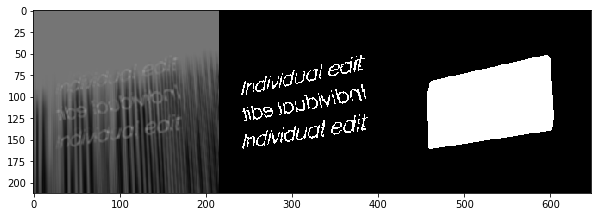

(1, 524, 444) (1, 524, 444)
(524, 444, 3)


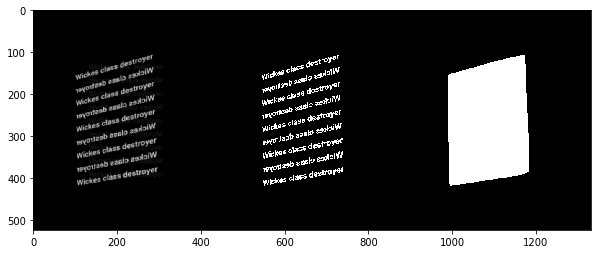

(1, 506, 382) (1, 506, 382)
(506, 382, 3)


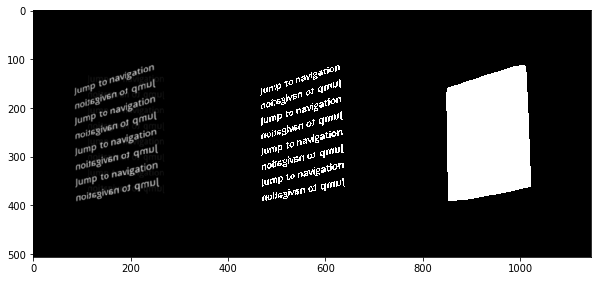

(1, 180, 423) (1, 180, 423)
(180, 423, 3)


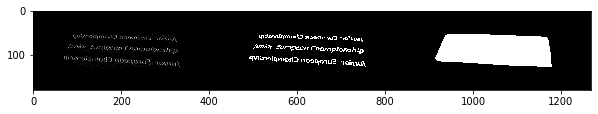

(1, 670, 329) (1, 670, 329)
(670, 329, 3)


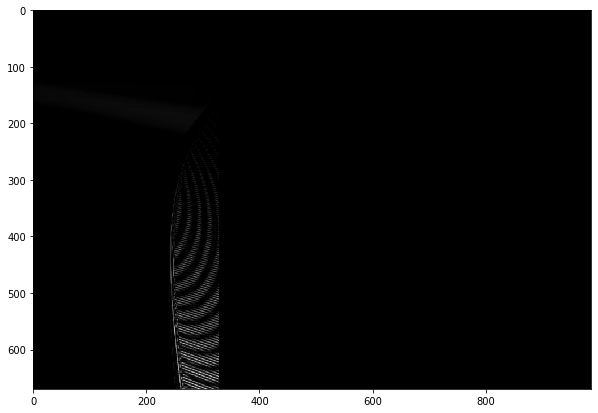

(1, 416, 156) (1, 416, 156)
(416, 156, 3)


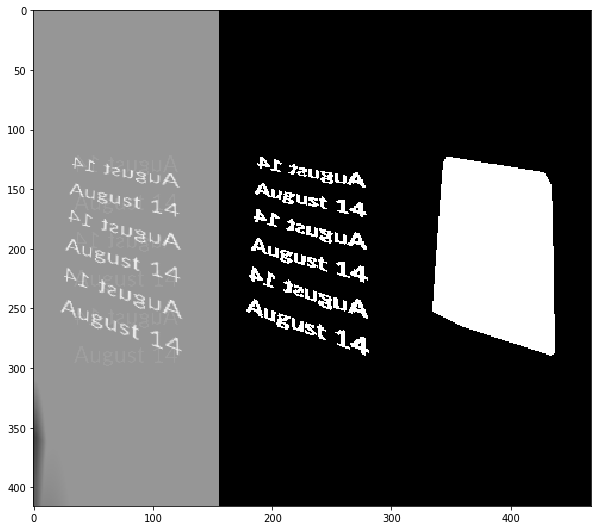

(1, 416, 956) (1, 416, 956)
(416, 956, 3)


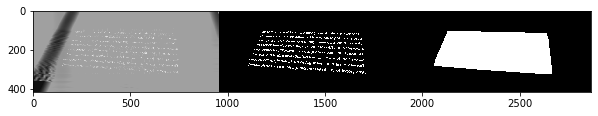

(1, 208, 654) (1, 208, 654)
(208, 654, 3)


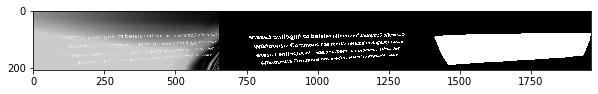

(1, 306, 392) (1, 306, 392)
(306, 392, 3)


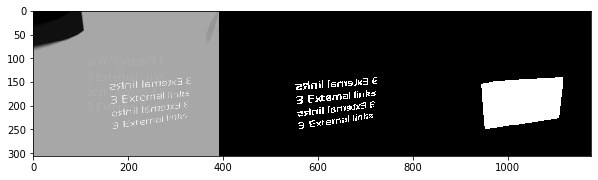

(1, 284, 85) (1, 284, 85)
(284, 85, 3)


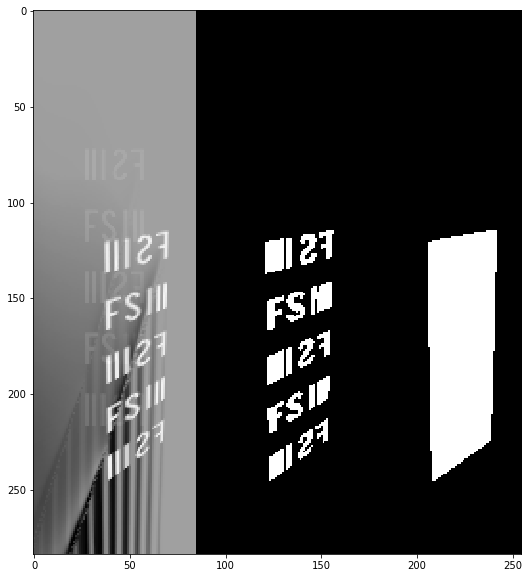

In [9]:
from torch.utils.data import DataLoader, ConcatDataset

batch_size_train=1

train_dataset = InfinityWordDataset(is_train=True,total_samples = 200, resolution=None, augmentation=True)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=4, drop_last=True)


for i_batch, sample_batched in enumerate(train_loader):
        if i_batch > 10:
            break
        image_np = sample_batched['image_original'].cpu().numpy()
        gt = sample_batched['gt'].cpu().numpy()
        seg_gt = sample_batched['seg_gt'].cpu().numpy()
        print(gt.shape, seg_gt.shape)
        for i in range(batch_size_train):
            print(image_np[i].shape)
            gt = np.squeeze(gt)
            seg_gt = np.squeeze(seg_gt)

            plt.imshow(np.hstack((image_np[i]/255. , np.dstack((gt,gt,gt)), np.dstack((seg_gt,seg_gt,seg_gt)))))
            plt.show()


Nessa próxima celula se da o treinamento do modelo 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
patience = 1000
nClasses = 2
max_epochs = 20000
model = UNetVgg(nClasses).to(device)
model_name = 'cleanner.pth'
class_weights = torch.tensor([3, 1.0]).float().to(device)

seg_model = torch.nn.Sequential(
        torch.nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=(1, 1)),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=(1, 1)),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(128, nClasses, kernel_size=1, stride=1, padding=0)
        ).to(device)
seg_name = 'seg.pth'

try:
    model.load_state_dict(torch.load(model_name))
except:
    pass

try:
    seg_model.load_state_dict(torch.load(seg_name))
except:
    pass

lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
# scheduler.step()
# alpha = 0.1

best_val_acc = -1
best_epoch = 0

# Start training...
for epoch in range(max_epochs):

    print('Epoch %d starting...' % (epoch+1))

    model.train()
    seg_model.train()

    mean_loss = 0.0

    n_correct = 0
    n_false = 0

    for i_batch, sample_batched in enumerate(train_loader):


        image = sample_batched['image'].to(device)
        gt = sample_batched['gt'].to(device)
        seg_gt = sample_batched['seg_gt'].to(device)

        #image = mixup_batch(image, alpha).to(device)
        
        
        optimizer.zero_grad()

        output, seg_feature = model(image)
        seg_out = seg_model(seg_feature)
#         print(output.size())
        _,_,H,W = output.size()
        seg_out = torch.nn.functional.interpolate(seg_out, size=(H,W), mode='bilinear', align_corners=False)
        
        attention = torch.nn.functional.softmax(seg_out, dim = 1)
        channelA = output[:,1,:,:] * attention[:,1,:,:]
        channelB = output[:,0,:,:] + attention[:,0,:,:]
        output  = torch.stack((channelB, channelA), 1)
#         print(output.size())
        softmax = torch.nn.functional.log_softmax(output, dim = 1)
        seg_softmax = torch.nn.functional.log_softmax(seg_out, dim = 1)
        
        loss = torch.nn.functional.nll_loss(softmax, gt, ignore_index=-1, weight=class_weights)
        
        

        seg_total_loss = torch.nn.functional.nll_loss(seg_softmax, seg_gt, ignore_index=-1, weight=class_weights)

        total_loss = seg_total_loss + loss
        
#         total_loss = focal_loss(output, gt)

        total_loss.backward()
        optimizer.step()

        mean_loss += total_loss.cpu().detach().numpy()

        # Measure accuracy

        gt = sample_batched['gt'].cpu().numpy()

        label_out = torch.nn.functional.softmax(output, dim = 1)
        label_out = label_out.cpu().detach().numpy()

        labels = np.argmax(label_out, axis=1)
        valid_mask = gt != -1
        curr_correct = np.sum(gt[valid_mask] == labels[valid_mask])
        curr_false = np.sum(valid_mask) - curr_correct
        n_correct += curr_correct
        n_false += curr_false

    mean_loss /= len(train_loader)
    train_acc = n_correct / (n_correct + n_false)
    print('Train loss: %f, train acc: %f' % (mean_loss, train_acc))
    for param_group in optimizer.param_groups:
        print(f'Learning Rate: {param_group["lr"]}')

    n_correct = 0
    n_false = 0

    model.eval()
    seg_model.eval()
    #create a new dataset to validation step 
    train_dataset.regenerate()
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(train_loader):
            if i_batch > 250:
                  break

            image = sample_batched['image'].to(device)
            image_np = np.squeeze(sample_batched['image_original'].cpu().numpy())
            gt = np.squeeze(sample_batched['gt'].cpu().numpy())
            

            label_out, seg_feature = model(image)
            seg_out = seg_model(seg_feature)
        
              
            _,_,H,W = label_out.size()
            seg_out = torch.nn.functional.interpolate(seg_out, size=(H,W), mode='bilinear', align_corners=False)
            
            attention = torch.nn.functional.softmax(seg_out, dim = 1)
            channelA = label_out[:,1,:,:] * attention[:,1,:,:]
              
            channelB = label_out[:,0,:,:] + attention[:,0,:,:]
            label_out  = torch.stack((channelB, channelA), 1)
              
            label_out = torch.nn.functional.softmax(label_out, dim = 1)
            label_out = label_out.cpu().detach().numpy()
            label_out = np.squeeze(label_out)

            seg_out = torch.nn.functional.softmax(seg_out, dim = 1)
            seg_out = seg_out.cpu().detach().numpy()
            seg_out = np.squeeze(seg_out)  
              
            labels = np.argmax(label_out, axis=0).astype(np.uint8)
            seg_out = np.argmax(seg_out, axis=0).astype(np.uint8)
              
              
            if 1 and i_batch % 2 == 0:
                cv2.imshow("Image", image_np.astype('u1'))
                cv2.imshow("label", labels*255)
                cv2.imshow("GT", gt.astype('u1')*255)
                cv2.imshow("seg", seg_out*255)
                cv2.waitKey(100)

            valid_mask = gt != -1
            curr_correct = np.sum(gt[valid_mask] == labels[valid_mask])
            curr_false = np.sum(valid_mask) - curr_correct
            n_correct += curr_correct
            n_false += curr_false


    total_acc = n_correct / (n_correct + n_false)

    if best_val_acc < total_acc:
        best_val_acc = total_acc
        step_donw = True

        if epoch > 7:
            torch.save(model.state_dict(), model_name)
            torch.save(seg_model.state_dict(), seg_name)
            print('New best validation acc. Saving...')
        best_epoch = epoch
#     if ((epoch - best_epoch) > (patience//2) ) and step_donw:
#         step_donw = False
#         scheduler.step()
    if (epoch - best_epoch) > patience:
        print("Fnishing training, best validation acc %f", best_val_acc)
        break

    print('Val acc: %f -- Best val acc: %f -- epoch %d.' % (total_acc, best_val_acc, best_epoch))